# Time series prediction using simple models

- stationarity
- time series prediction 

### import

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from pandas import read_csv

### utils

In [3]:
def read_tsv_utf8(path):
    return read_csv(path, sep='\t', encoding='utf-8') 

In [4]:
def date_from_str(str_date, format_date=''):
    if not format_date:
        format_date = "%Y-%m-%d"
    return datetime.datetime.strptime(str_date, format_date).date()

### read data

In [8]:
df = read_tsv_utf8("~/Documents/imagineML/data/time_series.tsv") 
columns = df.columns
df = df.drop([columns[0]], axis=1)
df['key_date'] = pd.to_datetime(df['key_date'], format='%Y-%m-%d')
df = df[df.columns[::-1]]
df = df.replace(np.nan, 0)

### stationarity

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.  
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [84]:
from statsmodels.tsa.stattools import adfuller
pd.options.display.float_format = '{:,.5f}'.format

df_stationary = pd.DataFrame(columns= 
                             ['item', 'ADF Statistic', 'p-value', 
                              'Critical Values: 1%', 'Critical Values: 5%', 'Critical Values: 10%'])

for item in df.columns[1:]:
    x = df[item]
    result = adfuller(x)
    critical_values = []
    for key, value in result[4].items():
        critical_values.append(value)
    values = [item, result[0], result[1]]
    values.extend(critical_values)
    df_stationary.loc[-1] = values  # adding a row
    df_stationary.index = df_stationary.index + 1  # shifting index
    df_stationary = df_stationary.sort_index()  # sorting by index  

#### show result

In [85]:
def _color_red_or_green(val):
    if val <= 0.05:
        return "background-color: green"
    return ""

stationary_ts = df_stationary[df_stationary['p-value'] <= 0.05]['item']
print('found stationary time series:', len(stationary_ts))
print('non-stationary time series:', len(df_stationary) - len(stationary_ts))

df_stationary.style.applymap(lambda x:_color_red_or_green(x), subset=['p-value'])

found stationary time series: 20
non-stationary time series: 14


,item,ADF Statistic,p-value,Critical Values: 1%,Critical Values: 5%,Critical Values: 10%
0,4911,-2.70555,0.073083,-3.64614,-2.95413,-2.61597
1,4752,-5.0332,1.90696e-05,-3.59664,-2.9333,-2.60499
2,5388,-6.15075,7.57288e-08,-3.59664,-2.9333,-2.60499
3,3442,-5.1443,1.14112e-05,-3.59664,-2.9333,-2.60499
4,3523,0.128193,0.967934,-3.6104,-2.93911,-2.60806
5,262,1.20249,0.996003,-3.6104,-2.93911,-2.60806
6,263,0.961196,0.993839,-3.6104,-2.93911,-2.60806
7,2870,-2.0281,0.274388,-3.60098,-2.93513,-2.60596
8,4822,-7.26178,1.67424e-10,-3.59664,-2.9333,-2.60499
9,4929,-5.27009,6.31334e-06,-3.59664,-2.9333,-2.60499


### move non-stationary to stationary

### seasonal line

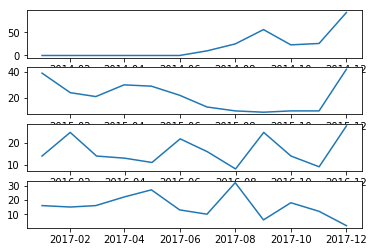

In [86]:
from pandas import TimeGrouper
from matplotlib import pyplot
import datetime

series = df[['key_date', stationary_ts[1]]]
series.set_index('key_date', inplace=True)
dts = pd.DataFrame({ 'date': pd.date_range(date_from_str('2014-01-01'),date_from_str('2014-06-01'), freq="MS") })
dts.set_index('date',inplace=True)
series = dts.append(series).replace(np.nan, 0)
#series
groups = series[:'2017'].groupby(TimeGrouper('A'))

pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

### density

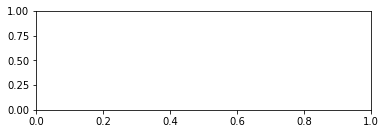

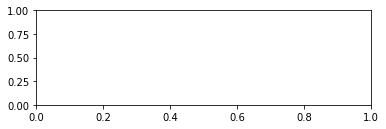

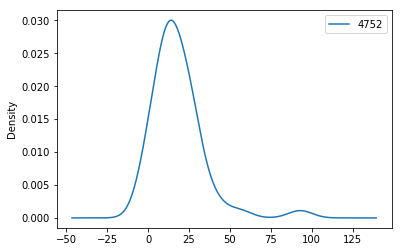

In [9]:
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

### box-plot

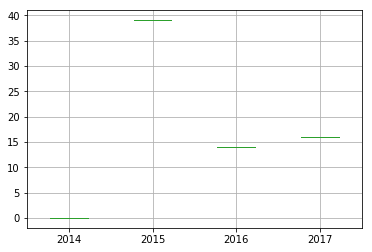

In [10]:
groups = series[:'2017'].groupby(TimeGrouper('A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values[0]
    
years.boxplot()
pyplot.show()

### prediction

In [88]:
# load required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

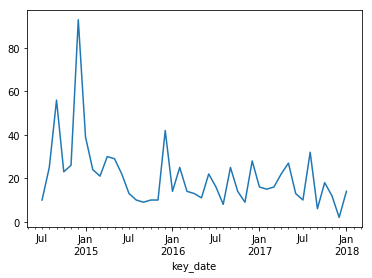

In [89]:
y = df[['key_date', stationary_ts[1]]]
# y['year'] = y['key_date'].dt.year
# y_train = y[y.year == 2016]['4752'].values
# y[['year','4752']]

y.set_index('key_date', inplace=True)
y4752 = y['4752']

y4752.plot()


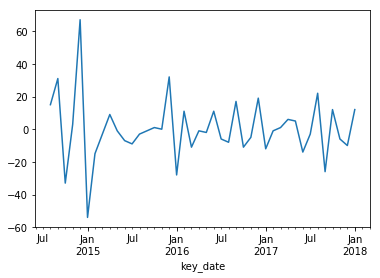

In [90]:
y4752.diff().plot()

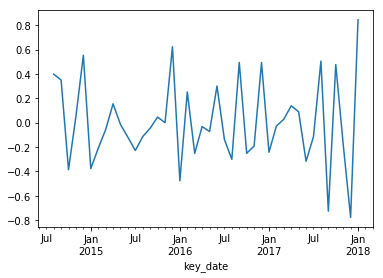

In [91]:
np.log10(y4752).diff().plot()

In [92]:
yt = np.log10(y4752).diff()
yt = yt[1:]
result = adfuller(yt)
print(result[1] <= 0.05)
y4752 = yt

True


In [93]:
y_train = y4752['2015':'2016']
y_test = y4752['2017':]

In [94]:
y_train

key_date
2015-01-01   -0.37742
2015-02-01   -0.21085
2015-03-01   -0.05799
2015-04-01    0.15490
2015-05-01   -0.01472
2015-06-01   -0.11998
2015-07-01   -0.22848
2015-08-01   -0.11394
2015-09-01   -0.04576
2015-10-01    0.04576
2015-11-01    0.00000
2015-12-01    0.62325
2016-01-01   -0.47712
2016-02-01    0.25181
2016-03-01   -0.25181
2016-04-01   -0.03218
2016-05-01   -0.07255
2016-06-01    0.30103
2016-07-01   -0.13830
2016-08-01   -0.30103
2016-09-01    0.49485
2016-10-01   -0.25181
2016-11-01   -0.19189
2016-12-01    0.49292
Name: 4752, dtype: float64

In [95]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
lag = range(0, 12)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, lag))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 1)
SARIMAX: (0, 0, 1) x (0, 0, 0, 2)
SARIMAX: (0, 0, 2) x (0, 0, 0, 3)
SARIMAX: (0, 0, 2) x (0, 0, 0, 4)


In [96]:
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y_train,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=Ture,
#                                             enforce_invertibility=False)

#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue


In [98]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
#             print("Unexpected error:", sys.exc_info()[0])
            continue
    
print("Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 0, 1)x(2, 0, 0, 11) model - AIC:2.273816973536091


In [100]:
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=best_pdq,
                                seasonal_order=best_seasonal_pdq,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

In [102]:
print(res.aic)
print(res.summary())

2.273816973536091
                                 Statespace Model Results                                 
Dep. Variable:                               4752   No. Observations:                   24
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 11)   Log Likelihood                   2.863
Date:                            Wed, 11 Apr 2018   AIC                              2.274
Time:                                    08:23:57   BIC                              6.986
Sample:                                01-01-2015   HQIC                             3.524
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4542      0.198     -2.290      0.022      -0.843      -0.065
ar.S.L11      -0.

In [103]:
from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=116)
chi

142.13816003902645

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4542      0.198     -2.290      0.022      -0.843      -0.065
ar.S.L11      -0.7702      0.305     -2.521      0.012      -1.369      -0.171
ar.S.L22      -0.9031      0.461     -1.960      0.050      -1.806   -9.34e-05
sigma2         0.0089      0.039      0.229      0.819      -0.068       0.086


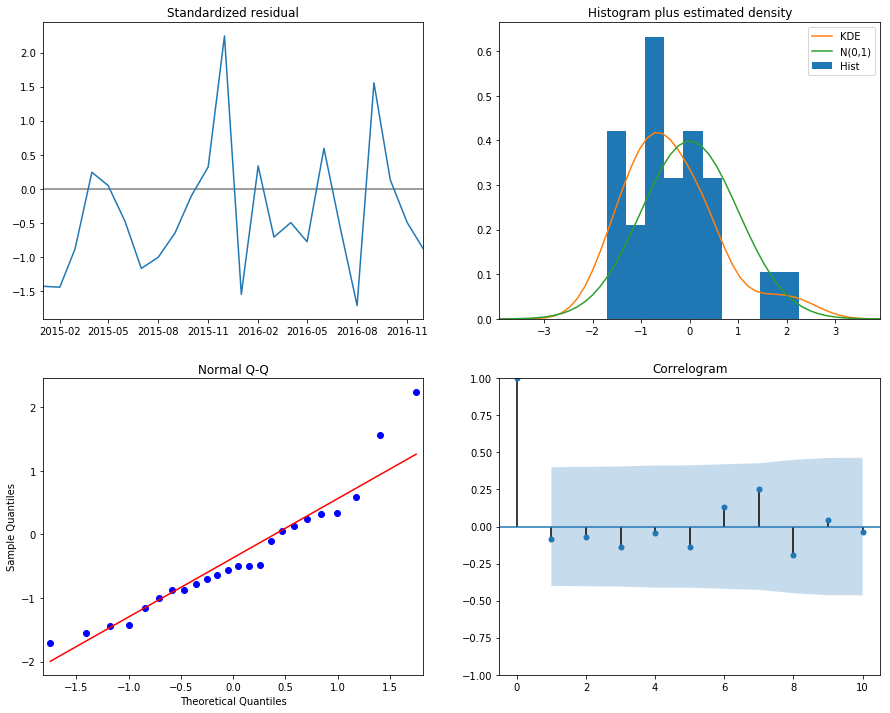

In [104]:
print(res.summary().tables[1])
res.plot_diagnostics(figsize=(15, 12))
plt.show()

In [105]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(y_train,
                                order=best_pdq,
                                seasonal_order=best_seasonal_pdq,
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2016-12-01'), 
                          end=pd.to_datetime('2017-07-01'),
                          dynamic=False)
pred_ci = pred.conf_int()

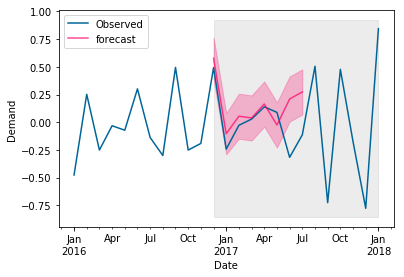

In [106]:
# plot in-sample-prediction
ax = y4752['2016':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend(loc='upper left')
plt.show()

In [107]:
import math

y_hat = pred.predicted_mean.values
y_true = y['2016-12-01':].values
 
# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()

print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 333.10 MSE (18.25 RMSE)
